In [1]:
#the import calls for the libraries being used by the solution
import matplotlib.pyplot as plt
import cv2

import numpy as np
from skimage.feature import hog
from skimage import data, exposure

import json
import os
import random
from scipy.ndimage.measurements import label

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

from sklearn.svm import LinearSVC

### Path Variables used for different functions

In [2]:
#the variables for the path used for different sets of functions

car_files_path = r"cars"
not_cars_files_path = r"not_cars"

#the current image of the dataset
curr_image = cv2.imread(r"C:\Users\UttkarshSharma\Downloads\benchmark_velocity_train\clips\102\imgs\040.jpg")

### Global variables for the model

In [3]:
#the svm classifier used as a global variable
global svm_clasifier

#the standard scaler being used for normalization
global standarad_scaler_X

### Helper Functions

In [4]:
def list_cars(path):
    
    #list varible storing the names of the files
    car_list = []
    
    for root, dirs, files in os.walk(path, topdown=False):
        car_list = files
    
    return car_list    

In [5]:
def boxed_image(image,box_list, thickness = 3 , color=(0, 255, 0)):
    
    #derived from the nearby pixel of Kmeans and watershed CV2 lab.
    #avoiding inmemory changes of the images, hence copy an image
    box_image = np.copy(image)
    
    #iterating over the list of the boxes.
    for box in box_list:
        #using the cv2.rectangle for bounding boxes
        cv2.rectangle(box_image, box[0] , box[1] , color, thickness)
    
    return box_image


In [6]:

def heating_map(heat_information, car_list):
    #derived from the nearby pixel of Kmeans and watershed CV2 lab.
    #put all of the pixels in the car's box as 1 and rest will be zero.
    
    for car in car_list:
        
        heat_information[ car[0][1] : car[1][1] , car[0][0]: car[1][0] ] +=1
    
    return heat_information


In [7]:
def image_threshold( image, threshold):
    
    image[ image <= threshold ] = 0
    
    return image


In [8]:

def final_boxes_image(image, labels):
    #REF - using scikit rectange documentation
    
    #we will have to iterate over the labels for the image
    for cars in range(labels[1]+1):
        
        #now we will find the values of the labels 
        location_pix = ( labels[0] == cars).nonzero()
        
        #now this will have a combination of x and y and we need to find the max.
        
        #for the x axis
        location_pix_Y = np.array(location_pix[0])
        
        #for the y axis
        location_pix_X = np.array(location_pix[1])
        
        #now we need to find the co-ordinates covering the max area
        location_X_min = np.min(location_pix_X)
        location_X_max = np.max(location_pix_X)
        
        location_Y_min = np.min(location_pix_Y)
        location_Y_max = np.max(location_pix_Y)
        
        #now we will use these to construct our x axis and y axis co-ordinates
        box = ( ( location_X_min , location_Y_min) , ( location_X_max , location_Y_max))
        
        cv2.rectangle(image, box[0], box[1] , (0,0,255), 4 )
    
    return image


### Main functions for the methodology

1. This function is used to calculate the Hog Features for the image
2. I am using the YCrCyB color space for extracting the hog features

In [9]:
def hog_features(path):
    
    #Ref :: https://en.wikipedia.org/wiki/Histogram_of_oriented_gradients
    
    #feature list for hogs
    feature_list = []
    
    #using the given path or root directory for the hog features.
    list_car_files = list_cars(path)
    
    
    for file in list_car_files:
        
        #the list for the hog features stored on a per channel basis.
        hog_features = []
        
        #creating the path for the image
        image_path = path + "\\" + file
        
        #we are converting the image to YCrCB so that we can run HOG features on it.
        curr_image = cv2.imread(image_path,cv2.COLOR_RGB2YCrCb)
        
        #setting the same size for our samples.
        width = 64
        height = 64
        
        #the dimesnsoins for our image
        dim = (width, height)
 
        # resizing the image to standard size, and using interpolation for reduction in noise
        resized = cv2.resize(curr_image, dim, interpolation = cv2.INTER_AREA)
        
        # we are running the hog features for all of the channels of the image
        for channel in range(resized.shape[2]):
            
            #computing the hog features for one channel of the image.
            hog_image = hog(resized[:,:,channel], orientations=9,pixels_per_cell=(8,8), cells_per_block =(2,2),visualize = False, feature_vector=True ,transform_sqrt=True ) 
            
            #appending the hog features to the list.
            hog_features.append(hog_image)
        
        #chaing the list to 1D array for the hog features.
        hog_features = np.ravel(hog_features)
        

        feature_list.append(hog_features)
    
    return feature_list
    

### Creating our Support Vector Machine for the classification of our images.

In [10]:
def classification_model_SVM(cars, not_cars):
    
    global svm_clasifier
    global standarad_scaler_X
    #i used numpy's vstack method for stacking my dataset of features.
    input_X = np.vstack((cars, not_cars)).astype(np.float64)
    
    #printing the shape of the input features
    print(input_X.shape)
    
    # i am using one hot encoding for the target dataset
    target_y = np.hstack((np.ones(len(cars)), np.zeros(len(not_cars))))
    
    #printing the shape of the target of the feature datset
    print(target_y.shape)
    
    #normalization of the dataset leveraging the standard scaler.
    standarad_scaler_X = StandardScaler().fit(input_X)

    # Apply the scaler to X
    normalized_X = standarad_scaler_X.transform(input_X)
    
    #testing of the normalized data
    print(normalized_X.shape)
    
    #randomizing the dataset and splitting it into train & test
    rand_state = np.random.randint(0, 100)
    X_train, X_test, y_train, y_test = train_test_split(normalized_X, target_y, test_size=0.2, random_state=rand_state)
    
    #printing the sizes for check
    print(len(X_train))
    print(len(y_train))
    
    #now we will run our SVM 
    svm_clasifier = LinearSVC()
    
    svm_clasifier.fit(X_train,y_train)
    
    # Check the score of the SVC
    print('Test Accuracy of SVC = ', round(svm_clasifier.score(X_test, y_test), 4))
    
    #return standarad_scaler_X , svm_clasifier
    

In [11]:
def model_infra():
    
    car_features = hog_features(car_files_path)
    not_car_features = hog_features(not_cars_files_path)
    
    print("Model being created and log-data")
    classification_model_SVM( car_features, not_car_features)
    
    

In [12]:
#model_infra()

In [13]:

def sliding_windows(image, x_range, y_range, x_y, window_size):
    #Ref :: https://medium.com/ai-quest/convolutional-implementation-of-the-sliding-window-algorithm-db93a49f99a0
    
#     image is our current image
#     x_range: type tuple is the range of x_axis area of interest
#     y_range : type tuple is the range of y_axis area of interest
#     window size : type tuple is the size of the sliding window
    
    #the list which will store the co-ordinates of our sliding windows -> we will return this list
    list_sliding_window = []
    
    #the size of the viewing window
    view_length  = x_range[1] - x_range[0]
    view_breadth = y_range[1] - y_range[0]
    
    #the number of windows present in the viewing windows
        
    #for the x-axis
    delta_x = np.int(window_size[0] * x_y[0]) #this is taken to account for overlapping sections
    
    #number of pixels present in a single window_size
    window_x_axis_pixels = np.int(window_size[0] * (1 - x_y[0]))
    
    #now we will caluclate the number of windows along the x axis(length) of the image
    X_windows_num = np.int( (view_length - delta_x)/window_x_axis_pixels)
    
    #now we will compute for the y axis for our image
    delta_y = np.int(window_size[1] * x_y[1])
    
    #numbe of pixels present in the y axis of the window.
    window_y_axis_pixels = np.int( window_size[1] * (1 - x_y[1]))
    
    #computatation of the number of windows along the y axis of the image.
    Y_windows_num = np.int( ( view_breadth - delta_y) / window_y_axis_pixels )
    
    #till now we have the co-ordinates for the windows for both the length and breadth of the image.
    
    for y in range(Y_windows_num):
        for x in range(X_windows_num):
            
            # for the starting positions of our window.
            x_begin = x * window_x_axis_pixels + x_range[0]
            y_begin = y * window_y_axis_pixels + y_range[0]
            
            #for the ending positions
            x_end = x_begin + window_size[0]
            y_end = y_begin + window_size[1]
            
            list_sliding_window.append( ( ( x_begin,y_begin) , ( x_end , y_end )) )
    
    return list_sliding_window

In [14]:
def list_sliding_windows(image):
    
    #Ref :: https://medium.com/ai-quest/convolutional-implementation-of-the-sliding-window-algorithm-db93a49f99a0
    
    list_windows_final = []
    
    #window size list
    window_sizes = [ (20,20),(60,60),(72,72),(100,100)]
    
    #the heigh list for the varying windows
    height_sizes = [(250,450) , (300,401) , (300,600) , (300,700)]
    
    #overlap window size
    overlap_sizes = [ (0.1,0.1), (0.85, 0.85),(0.7,0.7),(0.8,0.8)]
    
    range_X = [(0,1250) , (0,1280),(0,1280),(0,1190)]
    
    #temporary sizes of the windows
    temp_win_size = []
    
    #now we will iterate over our list
    
    for i in range(len(window_sizes)):
        
        #calling sliding windows to get the co-ordiantes of the windows
        wind = sliding_windows(image, x_range = range_X[i] , y_range = height_sizes[i] , x_y = overlap_sizes[i], window_size = window_sizes[i])
        temp_win_size.append(wind)
    
    #this list needs to be flattened for our analysis
    list_windows_final = sum(temp_win_size, [])
    
    return list_windows_final
    

In [15]:
#temp = list_sliding_windows(curr_image)

In [16]:
# img = boxed_image(curr_image,temp)

In [17]:
# plt.imshow(img)

In [18]:
#now we will do the classification of the window if there is car or not in the image
def car_not_car(image, list_windows , normalized_sclaer, SVM_classifier):
    
    #Ref :: https://www.elen.ucl.ac.be/Proceedings/esann/esannpdf/es2017-112.pdf 
    
    #the list having the possibility where cars are located.
    list_cars = []
    
    #the current image needs to be converted to the color frame
    image = cv2.cvtColor(image,cv2.COLOR_RGB2YCrCb)
    #plt.imshow(image)
    
    #iterating over the list of windows that we had created.
    for w in list_windows :
        
        #list for the fetures of the car.
        car_features = []
        
        #creating a sub-sample from our image - based on the window size.
        window = image[ w[0][1] : w[1][1] , w[0][0] : w[1][0] ]
        
        #standardization of the window
        width = 64
        height = 64
        
        #dimensions
        dim = (width, height)
 
        # resizing the image based on the window size 
        resized = cv2.resize(window, dim, interpolation = cv2.INTER_AREA)
        
        #list of the hog features 
        hog_features = []
        
        #running the hogs for all of the channels of the image.
        for channel in range(resized.shape[2]):
            
            hog_image = hog(resized[:,:,channel], orientations=9,pixels_per_cell=(8,8), cells_per_block =(2,2),visualize = False, feature_vector=True ,transform_sqrt=True )     
            hog_features.append(hog_image)
        
        #creating the 1D array for the features
        hog_features = np.ravel(hog_features)
        
        #joining the features along the same axis
        car_features.append(hog_features)
        
        #dimensionality match for the classifier 
        test_features = normalized_sclaer.transform(np.array(car_features).reshape(1, -1))
        
        prediction = SVM_classifier.predict(test_features)
        
        if prediction == 1:
            #print("yes")
            list_cars.append(w)
        
    return list_cars
        

### The driver section of the problem is defined here

In [19]:
#this is the current image 40th which will be passed to the function
#curr_image = cv2.imread(r"C:\Users\UttkarshSharma\Downloads\benchmark_velocity_train\clips\102\imgs\040.jpg")

### The creation of the model is done here

In [20]:
model_infra()

Model being created and log-data
(9666, 5292)
(9666,)
(9666, 5292)
7732
7732


C:\Users\UttkarshSharma\anaconda3\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


Test Accuracy of SVC =  0.9938


### the driver method call is here

In [21]:
def driver(image):
    
    #Ref https://www.elen.ucl.ac.be/Proceedings/esann/esannpdf/es2017-112.pdf 
    
    #the list of the sliding windows for the model
    temp = list_sliding_windows(curr_image)
    
    #the windows being superimposed on the model
    img = boxed_image(curr_image,temp)
    
    plt.imshow(img)
    
    #finding the location of the windows where cars is present
    cars = car_not_car(curr_image , temp, standarad_scaler_X , svm_clasifier)
    
    len(cars)
    
    #creating a mask using the dimensions of the image for the heat map
    heat = np.zeros_like(curr_image[:,:,0]).astype(np.float)
    
    #using the windows and defining the heat
    heat = heating_map(heat,cars)
    
    #using threshold to define the pixels.
    heat = image_threshold(heat,2)

    # using np.clip to normalize the data values for the heatmap.    
    heatmap = np.clip(heat, 0, 255)
    
    #creation of the labels for the heatmap
    labels = label(heatmap)
    
    #finding the pixels for the detected objects
    detected_cars = final_boxes_image(np.copy(curr_image), labels)
    
    #displaying the image of the heatmap
#     plt.imshow(heatmap, cmap='hot')
#     plt.title('Heat Map')
    
    plt.imshow(detected_cars)
    plt.title("Cars being detected")
    

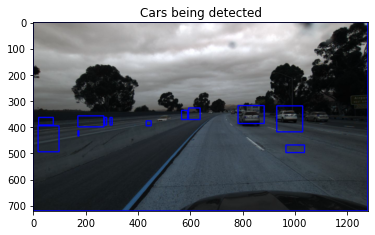

In [22]:
curr_image = cv2.imread(r"C:\Users\UttkarshSharma\Downloads\benchmark_velocity_train\clips\1\imgs\040.jpg")

driver(curr_image)